In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , LSTM , Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import pickle

In [ ]:
data = pd.read_csv("/content/reviews_data.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:

data.shape

(100000, 10)

In [ ]:

data.isna().sum().to_frame(name='# of missing values')

,# of missing values
Id,0
ProductId,0
UserId,0
ProfileName,4
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,2
Text,0


In [ ]:
total_rows =  data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows= data.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 6

Percentage of data removed:0.01%
Percentage of data remaining:99.99%


In [ ]:
a =  data.shape[0]
data.drop_duplicates(inplace=True, subset=['Score','Text'])
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 11561

Percentage of data removed: 11.56%
Percentage of data remaining: 88.43%


In [ ]:
a =  data.shape[0]

idx = data[data["HelpfulnessNumerator"]>data["HelpfulnessDenominator"]].index
data.drop(index=idx, inplace=True)

b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed:{np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((b/total_rows)*100,2)}%")

No. of rows removed : 2

Percentage of data removed:0.0%
Percentage of data remaining:88.43%


In [ ]:
## `Score` > 3 : "Positive" 
## `Score` == 3 : "Neutral"
## `Score` < 3 : "Negative"

def create_target(x):
    
    return "Positive" if x>3 else "Negative" if x<3 else "Neutral"

data.loc[:, 'target'] = data.Score.apply(create_target)

In [ ]:
data[['Score', 'target']].sample(5)

,Score,target
91302,4,Positive
72655,5,Positive
74581,5,Positive
74174,4,Positive
76526,5,Positive


In [ ]:
data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive
...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,B000LQORDE,A2P7HIRYYWVOBD,Mason,2,5,5,1254096000,yummy!,I just love it and will buy another box when I...,Positive
99996,99997,B000LQORDE,A1K0ZH5MQFBA77,jennilight,2,5,4,1250985600,Tastes like More!,My late father in law used to have a rating sy...,Positive
99997,99998,B000LQORDE,A29FRN2O7LWINL,T. Tsai,2,5,5,1237766400,Great ramen,This is my favorite brand of Korean ramen. It ...,Positive
99998,99999,B000LQORDE,A9Q950IPXJR1D,"Lynda ""casual customer""",2,5,4,1237161600,Spicy!!,"I do like these noodles although, to say they ...",Positive


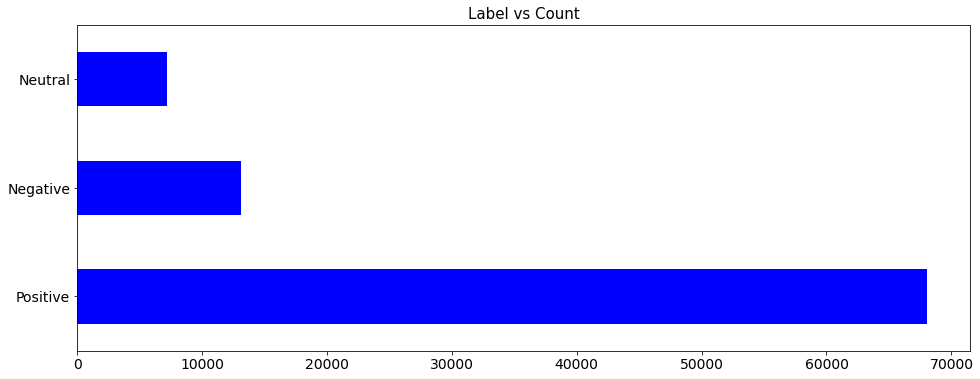

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

In [ ]:
neutral = data.loc[data.target=="Neutral"] # 29770 reviews

positive = data.loc[data.target=="Positive"].sample(10000)

negative = data.loc[data.target=="Negative"].sample(10000)

data = pd.concat([positive, negative, neutral])
data.shape

(27202, 11)

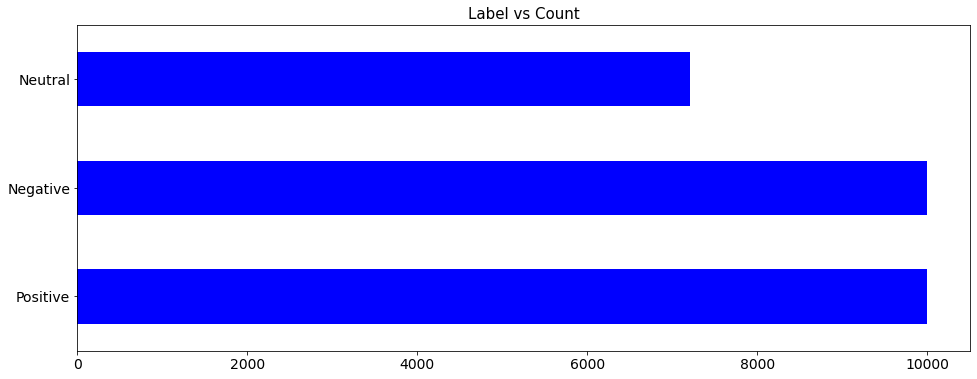

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

In [ ]:
  import nltk
  nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# stopwords
total_stopwords = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords 
                          if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

# 
final_stopwords.add("one")
print(final_stopwords)

{'most', 'only', 'hadn', 'does', 'again', 'on', 'doing', 'in', 'was', 'y', 'here', 'yourself', 'so', 'haven', 'shan', "you've", 'we', 'd', 'do', 'against', 'themselves', 'while', 'same', 'll', 'each', 'couldn', 'from', 'further', 'there', 'aren', 'ourselves', 'am', 'these', "it's", 'than', 'up', 'himself', 'how', 'wasn', 're', 'its', 'or', 'other', 'to', 't', 'more', 'for', 'own', 've', 'they', 'their', 'such', 'being', 'during', 'when', 'one', 'above', 'i', 'whom', 'm', 'can', 'where', 'her', 'isn', 'under', "you'll", 'as', 'between', "she's", 'doesn', 'an', 'his', 'before', 'a', 'too', 'you', 'it', 'will', 'those', 'weren', 'by', 'ain', 'ma', 'out', 'me', 'yourselves', 'which', 'mightn', "that'll", 'below', 'at', 'through', 'why', 'our', 'has', "should've", 'with', 'down', 'this', 'have', 'the', 'wouldn', 'don', 'until', 'hasn', 'what', 'of', 'who', 'because', 'my', 'o', 'then', 'she', 'off', 'were', 'and', 'been', 'he', 'into', 'hers', 'if', 'after', 'herself', 'shouldn', 'theirs', 

In [ ]:
#stemming object
stemmer = PorterStemmer()

# ---------------------------------------------
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")

In [ ]:
def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)
    
    # remove digits
    review = review.translate(remove_digits)
    
    # lower case all letters
    review = review.lower()
    
    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()
    
    # remove stop words
    review = [word for word in review.split()
              if word not in final_stopwords]
    
    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])
    
    return review

In [ ]:
print("Before preprocessing : ")
data.Text.iloc[6]

Before preprocessing : 


'I like these flakes a lot!  However, if you are looking for a strong honey flavor, these do not have it.  They are so lightly sweetened that I crushed them and used them as a crumb topping for a chicken casserole!  We also used them to make peanut butter cereal bars and the sweetness did not interfere with the recipe. They are a thicker flake than traditional corn flakes, crunchy rather than crispy  I will continue purchasing them for breakfast and other recipes as well.'

In [ ]:

data.Text = data.Text.apply(preprocessor) 
print("After preprocessing : ")
data.Text.iloc[6]

After preprocessing : 


'like flake lot howev look strong honey flavor not lightli sweeten crush use crumb top chicken casserol also use make peanut butter cereal bar sweet not interfer recip thicker flake tradit corn flake crunchi rather crispi continu purchas breakfast recip well'

In [ ]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)
    
    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

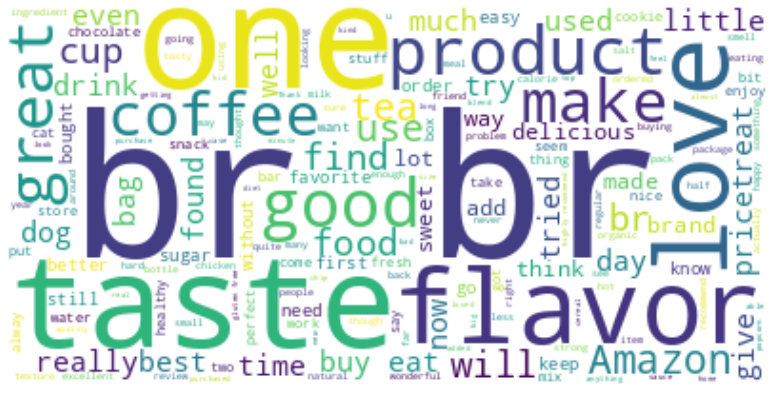

In [ ]:
pos = data.loc[data.target=="Positive"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

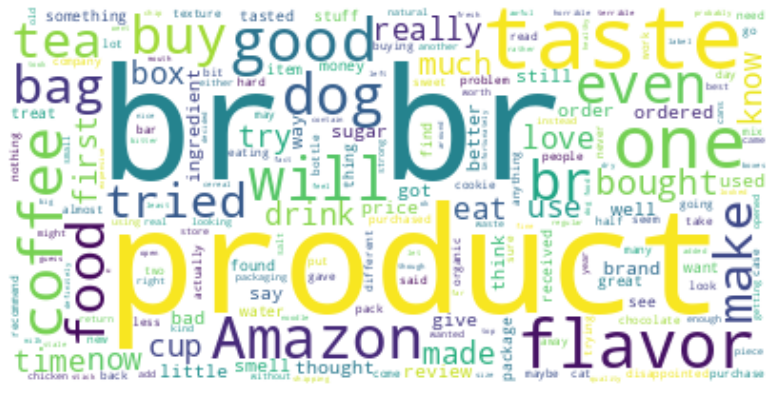

In [ ]:
pos = data.loc[data.target=="Negative"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

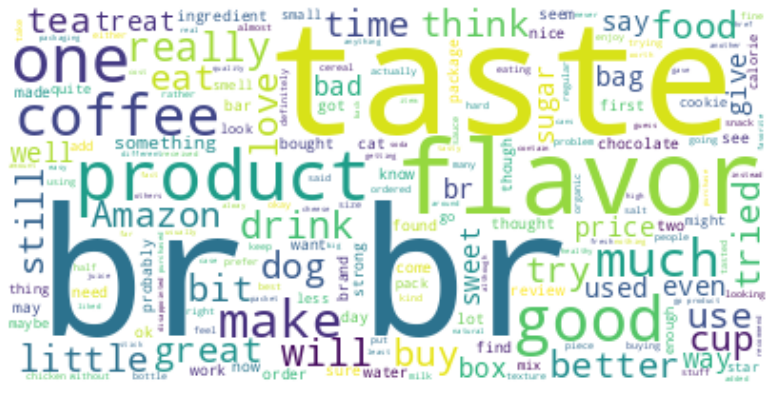

In [ ]:
pos = data.loc[data.target=="Neutral"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

In [ ]:
X = data.Text
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    
    X, y, test_size=0.20, random_state=1, stratify=y)

In [ ]:
X_train.shape, X_test.shape

((21761,), (5441,))

In [ ]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

In [ ]:
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) # index-> class

['Negative', 'Neutral', 'Positive']


In [ ]:
def train_and_eval(model, trainX, trainY, testX, testY):
    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

In [ ]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.6734525067781811
Test accuracy score : 0.666421613673957

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.7580993520518359
Test accuracy score : 0.7026281933468113

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.8439409953586692
Test accuracy score : 0.709612203639037

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.9290473783373926
Test accuracy score : 0.6783679470685535

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.9767933458940306
Test accuracy score : 0.6485940084543282

 ----------------------------------------


In [ ]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.7689444418914572
Test accuracy score : 0.6607241315934571

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7551583107393962
Test accuracy score : 0.6848005881271825

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7508386563117504
Test accuracy score : 0.6860871163389083

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7482652451633657
Test accuracy score : 0.6866384855725051

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.7466568631956252
Test accuracy score : 0.6866384855725051

 ----------------------------------------


In [ ]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.5947796516704196
Test accuracy score : 0.585737915824297

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.6233628969256928
Test accuracy score : 0.611652269803345

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.7208308441707643
Test accuracy score : 0.6932549163756663

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.8070860714121594
Test accuracy score : 0.7180665318875207

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.9028996829189835
Test accuracy score : 0.6925197573975372

 ----------------------------------------


In [ ]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.7931620789485777
Test accuracy score : 0.6528211725785701

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7712880841873075
Test accuracy score : 0.682227531703731

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.754882588116355
Test accuracy score : 0.6903142804631501

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7483111989338725
Test accuracy score : 0.6884763830178277

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.7417398097513901
Test accuracy score : 0.6875574342951664

 ----------------------------------------


In [ ]:
def plot_cm(y_true, y_pred):
    plt.figure(figsize=(6,6))
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    sns.heatmap(
        cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
        xticklabels=labels, yticklabels=labels)
    
    return plt.show()

In [ ]:
bmodel = LogisticRegression(C=1, max_iter=500, random_state=1)
bmodel.fit(tfidf_X_train, y_train)

LogisticRegression(C=1, max_iter=500, random_state=1)

In [ ]:
# predictions
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)

In [ ]:
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")

Train accuracy score : 0.8070860714121594
Test accuracy score : 0.7180665318875207


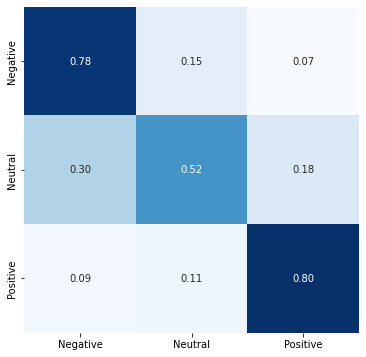

In [ ]:
plot_cm(y_test, y_preds_test)

In [ ]:
with open("transformer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
    
with open("model.pkl", "wb") as f:
    pickle.dump(bmodel, f)

In [ ]:
# labels = ['Negative', 'Neutral', 'Positive']
def get_sentiment(review):
    # preprocessing
    x = preprocessor(review)
    #vectorization
    x = tfidf_vectorizer.transform([x])
    #prediction
    y = int(bmodel.predict(x.reshape(1,-1)))
    return labels[y]

In [ ]:
# positve review
review = "This chips packet is very tasty. I highly recommend this!"
print(f"This is a {get_sentiment(review)} review!")

This is a Positive review!


In [ ]:

# positve review
review = "This product is a waste of money. Don't buy this!!"
print(f"This is a {get_sentiment(review)} review!")

This is a Negative review!


In [ ]:
review = "The only difference in my purchase of this produce from Amazon rather than from<br />my local store is that I do not have to carry it in from the car and the prime<br />time shipping does create enough decrease in the cost per pound that I see it as<br />a convenient and economical choice of purchase."
print(f"This is a {get_sentiment(review)} review!")

This is a Neutral review!
